In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt 
import matplotlib.pyplot as mplot 
import matplotlib.patches as patches

from matplotlib.colors import ListedColormap
import os
import subprocess
import sklearn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score,  precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
 
import random
 

from sklearn.preprocessing import StandardScaler


from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import keras
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.utils import plot_model


import pickle 


import shap
import lime
from lime import lime_tabular
import random

import dalex as dx 

from sklearn.tree import export_graphviz
import pydotplus
import seaborn as sns

from tabulate import tabulate 

import tensorflow as tf
from tensorflow.keras import layers, Input
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.metrics import AUC, Precision, Recall, F1Score
from tensorflow.keras.utils import plot_model

# Define custom metrics
recall = Recall()
precision = Precision()
f1_score = F1Score()
auc = AUC()






In [8]:
dataSetIndex = 6
needToMakePictureOfTrees = 0
''' ---------------------------------------------------------- '''
dataSetFilePath = ""
dataSetName = ""
dataSetResultDirectory = "./"

if(dataSetIndex == 0):
    dataSetFilePath = "./heartDisease/0_statLog_dataSet.csv"
    dataSetName = "SateLog_DataSet"
elif (dataSetIndex == 1):
    dataSetFilePath = "./heartDisease/1_heart_statlog_cleveland_hungary_final.csv"
    dataSetName = "ALL_StateLog_CleveLand_Hungary"
elif (dataSetIndex == 2):
    dataSetFilePath = "./heartDisease/2_cleveland.csv"
    dataSetName = "Cleveland"
elif (dataSetIndex == 3):
    dataSetFilePath = "./heartDisease/3_framingham.csv"
    dataSetName = "framingham"
elif (dataSetIndex == 4):
    dataSetFilePath = "./heartDisease/4_CardiacPrediction.xlsx"
    dataSetName = "CardiacPrediction"
elif (dataSetIndex == 5):
    dataSetFilePath = "./heartDisease/5_CardiacPredictionLessDimensions.xlsx"
    dataSetName = "CardiacPrediction"
elif (dataSetIndex == 6):
    dataSetFilePath = "./heartDisease/6_CardiacPredictionFewDimensions.xlsx"
    dataSetName = "CardiacPrediction"
else:
    dataSetFilePath = ""
    dataSetName = ""

if(dataSetIndex==4 or dataSetIndex==5 or dataSetIndex==6):
    #fileData = pd.read_excel(dataSetFilePath, sheet_name='CoroHeartDis')
    fileData = pd.read_excel(dataSetFilePath)
else:
    fileData = pd.read_csv(dataSetFilePath)

print("Shape of fileData: {}".format(fileData.shape))
print("Column Headings: {}".format(fileData.__dataframe__().column_names()))
print("Number of Records: {}".format(fileData.__dataframe__().num_rows()))


missingValues = fileData.isnull().any().sum()
print(f"\nNumber of Missing Values: {missingValues}")

num_rows_before = fileData.shape[0]
# Remove duplicate records based on all columns
fileData.drop_duplicates(inplace=True)
# Check the number of rows after removing duplicates
num_rows_after = fileData.shape[0]
# Print the number of duplicate records removed
num_duplicates_removed = num_rows_before - num_rows_after
print(f"Number of duplicate records removed: {num_duplicates_removed}")
 
 # Preprocess Steps from the ChatGPT
# 1. Handling Missing Values:
fileData = fileData.dropna()
print("Shape of fileData: {}".format(fileData.shape))              
#fileData.replace({'?': np.nan}).dropna().astype(float)
#fileData = fileData.fillna(0) 

fileData = fileData.fillna(0) 

print("Shape of fileData End: {}".format(fileData.shape))



finalResultTable = [ ['Index', 'Method', 'Accuracy %','Recall %','Precision %','F1 Score','AUC'], ]  

#X = fileData.drop(fileData.__dataframe__().column_names()[-1], axis=1)  # Features

cols = ['Triglycerides','Blood-Rel-Diabetes','Gender','Blood-Rel-Stroke','Cholesterol','Body-Mass-Index','Diabetes','Diastolic','Basophils','Eosinophils','Height','Albumin','Phosphorus','Total-Cholesterol','LDH','Weight','Protein','White-Blood-Cells','AST','Uric.Acid']

X = fileData[cols]
Y = fileData[fileData.__dataframe__().column_names()[-1]]  # Labels

columns = fileData.__dataframe__().column_names() 
totalRecords = (fileData.__dataframe__().num_rows())

print("\n")
print("columns of x:: {} \n\n and features of X: {}".format(len(X.columns), X.columns))

dataSetResultDirectory = "./"
dataSetResultDirectory += ("DatasetResults_MLP_with_AttentionLayers_loaded_SHAP_Features_" + dataSetName)
dataSetResultDirectory += "/"
if not os.path.isdir(dataSetResultDirectory):
    os.makedirs(dataSetResultDirectory)

dataSetName += "_{}".format(fileData.shape)


print("Shape of fileData: {} , target Len:{}".format(fileData.shape, len(Y)))
print("X: {} , Y:{}".format(X.shape, Y.shape))
#print("\n\nX: head:: \n{}".format(X.head()))
#print("\n\nY: head::\n {}".format(Y.head()))

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
print("Target Column Name:: {} \n".format(fileData.__dataframe__().column_names()[-1]))
rus = RandomUnderSampler(random_state=42)
smote = SMOTE(random_state=42)
# Oversample the minority class using SMOTE
X_train, y_train = smote.fit_resample(X_train, y_train)
#X_test, y_test = rus.fit_resample(X_test, y_test)
X_test, y_test = smote.fit_resample(X_test, y_test) 

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n X Train: Shape:: {}".format(X_train.shape))
print(" X Test: Shape:: {}".format(X_test.shape))   
positiveClass =  0
negativeClass = 0
for i in y_train:
    if(i == 0): negativeClass += 1
    if(i == 1): positiveClass += 1
print("Train DataSet Positive Class Records:: {}".format(positiveClass)) 
print("Train DataSet Negative Class Records:: {}".format(negativeClass)) 
print("Train DataSet Total Records:: {}".format(positiveClass + negativeClass)) 
print("\n\n") 
positiveClass =  0
negativeClass = 0
for i in y_test:
    if(i == 0): negativeClass += 1
    if(i == 1): positiveClass += 1
print("Test DataSet Positive Class Records:: {}".format(positiveClass)) 
print("Test DataSet Negative Class Records:: {}".format(negativeClass)) 
print("Test DataSet Total Records:: {}".format(positiveClass + negativeClass)) 

X_train_normalized = tf.keras.utils.normalize(X_train, axis=1)
X_test_normalized = tf.keras.utils.normalize(X_test, axis=1)

scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.fit_transform(X_test) 
# Our vectorized labels
X_train_f32 = np.asarray(X_train).astype(np.float32)  #.astype('float32').reshape((-1,1))
X_test_f32 = np.asarray(X_test).astype(np.float32)
#y_train_scaler = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test_scaler = np.asarray(y_test).astype('float32').reshape((-1,1))
# Separate features and target variable
features = X_train_scaler # data.iloc[:, :-1]
target = np.asarray(y_train).astype('float64').reshape((-1,1))  #data['CoronaryHeartDisease']
print("X_train shape: {}   and dType: {}".format(X_train.shape, len(X_train.columns)))
print("X_train_scaler shape: {}   and dType: {}".format(X_train_scaler.shape, X_train_scaler.dtype))
print("X_test_scaler shape: {}   and dType: {}".format(X_test_scaler.shape, X_test_scaler.dtype)) 
print("y_train shape: {}   and dType: {}".format(y_train.shape, y_train.dtype))  
print("y_test_scaler shape: {}   and dType: {}".format(y_test_scaler.shape, y_test_scaler.dtype))  
print("features shape: {}   and dType: {}".format(features.shape, features.dtype))
print("target shape: {}   and dType: {}".format(target.shape, target.dtype)) 


print("\n\n\n ------------------------------------------------------------")
print(" Directory Path: {} ".format(dataSetResultDirectory))
print(" ------------------------------------------------------------")


Shape of fileData: (37079, 40)
Column Headings: Index(['Gender', 'Age', 'X60-sec-pulse', 'Systolic', 'Diastolic', 'Weight',
       'Height', 'Body-Mass-Index', 'White-Blood-Cells', 'Lymphocyte',
       'Monocyte', 'Eosinophils', 'Basophils', 'Red-Blood-Cells', 'Hemoglobin',
       'Platelet-count', 'Segmented-Neutrophils', 'Hematocrit', 'Albumin',
       'ALP', 'AST', 'ALT', 'Cholesterol', 'Creatinine', 'Glucose', 'Iron',
       'LDH', 'Phosphorus', 'Bilirubin', 'Protein', 'Uric.Acid',
       'Triglycerides', 'Total-Cholesterol', 'HDL', 'Glycohemoglobin',
       'Moderate-work', 'Diabetes', 'Blood-Rel-Diabetes', 'Blood-Rel-Stroke',
       'CoronaryHeartDisease'],
      dtype='object')
Number of Records: 37079

Number of Missing Values: 0
Number of duplicate records removed: 0
Shape of fileData: (37079, 40)
Shape of fileData End: (37079, 40)


columns of x:: 20 

 and features of X: Index(['Triglycerides', 'Blood-Rel-Diabetes', 'Gender', 'Blood-Rel-Stroke',
       'Cholesterol', 'Body-M

In [4]:
from pathlib import Path
 
modelPath = Path("./DatasetResults_MLP_After_XAI_Features_Selection_Experiment_1_CardiacPrediction/model02_trained_CardiacPrediction_(37079, 51)_20240111_1214_0.9139724373817444percent.model")
shapExplainerPath = Path("./DatasetResults_MLP_After_XAI_Features_Selection_Experiment_1_CardiacPrediction/ShapeExplainer_20240111_1214_91.40percent.pkl")
shapValuesPath = Path("./DatasetResults_MLP_After_XAI_Features_Selection_Experiment_1_CardiacPrediction/ShapeExplainerValues_20240111_1214_91.40percent.pkl")


import pickle

if modelPath.exists(): print(f"Yes! The file path MLP Model exists.")
else: print(f"The file path MLP Model does not exist.")


loadedModel = 0
loadedExplainer = 0
loadedShapValues = 0

 
# To load the saved explainer and SHAP values later:
loaded_model = tf.keras.models.load_model(modelPath)


Yes! The file path MLP Model exists.



In [5]:
import time

batchSize  = 1
numberofFeatures = 20
single_instance = np.random.rand(batchSize, numberofFeatures)
single_instance = np.asarray(single_instance)
start_time = time.time()
predictions = loaded_model.predict(single_instance)  # Expand dimensions if needed
end_time = time.time()
prediction_time_single = end_time - start_time
prediction_time_single_ms = prediction_time_single * 1000
print(f"Prediction Time for {single_instance.shape[0]} (miliSec): ", prediction_time_single_ms)


batchSize  = 500
single_instance = np.random.rand(batchSize, numberofFeatures)
single_instance = np.asarray(single_instance)
start_time = time.time()
predictions = loaded_model.predict(single_instance)  # Expand dimensions if needed
end_time = time.time()
prediction_time_single = end_time - start_time
prediction_time_single_ms = prediction_time_single * 1000
print(f"Prediction Time for {single_instance.shape[0]} (miliSec): ", prediction_time_single_ms)



1/1 [==============================] - 0s 291ms/step
Prediction Time for 1 (miliSec):  397.5989818572998
16/16 [==============================] - 0s 3ms/step
Prediction Time for 500 (miliSec):  224.96414184570312


In [6]:
if shapExplainerPath.exists(): print(f"Yes! The file path SHAP Explainer exists.")
else: print(f"The file path SHAP Explainer does not exist.")
if shapValuesPath.exists(): print(f"Yes! The file path SHAP Values exists.")
else: print(f"The file path SHAP Values does not exist.")



# Register the AttentionLayer class before loading the model
@tf.keras.utils.register_keras_serializable(package="AttentionLayer")
class AttentionLayer(tf.keras.layers.Layer):
    def call(self, inputs, **kwargs):
        q, v = inputs
        attention = tf.keras.layers.Attention()([q, v])
        return attention
     

# To load the saved explainer and SHAP values later:
#with open(("./DatasetResults_MLP_with_AttentionLayers_imBalancedCardiacPrediction/ShapeExplainer_20240109_1946_95.98percent.pkl"), 'rb') as explainer_file:
#     loadedExplainer = pickle.load(explainer_file)

with open(shapValuesPath, 'rb') as shap_values_file:
     loadedShapValues = pickle.load(shap_values_file)

Yes! The file path SHAP Explainer exists.
Yes! The file path SHAP Values exists.


Total Features: 56914 -> Selected for SHAP:: 3983
Total Test: 14228 -> Selected for SHAP:: 995


--------------------------------------------------
--------------------------------------------------
Top SHAP values:
0, 1, Blood-Rel-Diabetes, 0.008166778183568245
1, 0, Triglycerides, 0.005776828574968382
2, 4, Cholesterol, 0.005277468538865546
3, 2, Gender, 0.003938773185500308
4, 15, Weight, 0.00252259271741176
5, 16, Protein, 0.0024671625528747496
6, 6, Diabetes, 0.0024228451920529684
7, 5, Body-Mass-Index, 0.0022356489313952073
8, 19, Uric.Acid, 0.0017803594974050128
9, 12, Phosphorus, 0.0015063073817826228
10, 8, Basophils, 0.0010351948012181768
11, 7, Diastolic, 0.0005178837153181593
12, 10, Height, 0.00031405942486609076
13, 14, LDH, -8.675959575458243e-05
14, 17, White-Blood-Cells, -0.0008389748293993662
15, 3, Blood-Rel-Stroke, -0.0012404857157780266
16, 13, Total-Cholesterol, -0.002245674389531239
17, 11, Albumin, -0.0022728389716955726
18, 9, Eosinophils, -0.002917202230409818

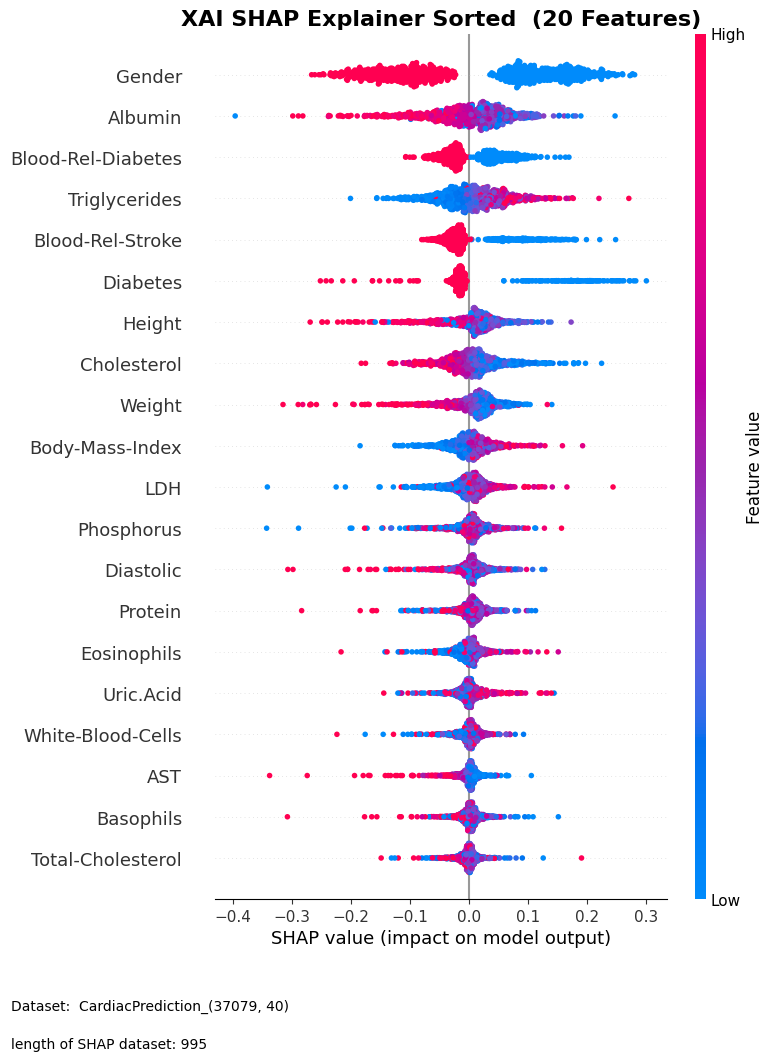

In [10]:
shap_values = loadedShapValues
feature_names = X.columns.tolist()
percentage = 0.07
numberOfFeatures = int(len(features) *percentage)
print("Total Features: {} -> Selected for SHAP:: {}".format(len(features), numberOfFeatures))
featuresForShap = X_train.columns #features[0:numberOfFeatures]
#print(" Features Name: {}".format(  featuresForShap))

numberOftest = int(len(X_test_scaler) * percentage)
print("Total Test: {} -> Selected for SHAP:: {}".format(len(X_test_scaler), numberOftest))
testForShap = X_test_scaler[0:len(featuresForShap)]
testForShap = X_test_scaler[0:numberOftest]
#print(" testForShap Name: {}".format(  testForShap))

avg_shap_values2 = {}
howManyFeatures = 20
# Calculate feature importance based on the mean absolute SHAP values
feature_importance = (shap_values).mean(axis=0)
top_features_indices_Sorted = np.argsort(feature_importance)[::-1] 
top_features_indices = np.argsort(feature_importance)[::-1][:howManyFeatures]
# Select only the top features and corresponding SHAP values
featureNamesSHAP = X.columns[top_features_indices_Sorted]
top_features = testForShap[:, top_features_indices_Sorted]
top_shap_values = shap_values[:, top_features_indices_Sorted] 

print("\n\n--------------------------------------------------")
print("--------------------------------------------------")
print("Top SHAP values:")
for i in range(len(top_features_indices_Sorted)):
    feature_index = top_features_indices_Sorted[i]
    feature_name = feature_names[feature_index]
    shap_value = (top_shap_values[:, i]).mean(axis=0) #np.mean(np.abs(shap_values[:, i]))
    avg_shap_values2[i]= (shap_value * 100.0)
    print(f"{i}, {feature_index}, {feature_name}, {shap_value }")
    #print(f"{feature_name}, { shap_value}")
 
top_10_shap_values = shap_values[:, top_features_indices] 
top_10_feature_names = X.columns[top_features_indices]
# Create a DataFrame for visualization
 
df_top_10 = pd.DataFrame(data=top_10_shap_values, columns=top_10_feature_names)

shap.summary_plot(top_10_shap_values, testForShap[:, top_features_indices], feature_names=top_10_feature_names, show=False)

ax = mplot.gca() 
ax.set_title("XAI SHAP Explainer Sorted  ({} Features)".format(howManyFeatures) ,fontsize=16, fontweight='bold')     
dataSetString = "Dataset:  {}".format(dataSetName)
testingDatasetString ="length of SHAP dataset: {}".format(len(testForShap)) 
ax.figure.text(0.020, -0.05,  dataSetString, horizontalalignment='left', wrap=False )  
ax.figure.text(0.020, -0.09,  testingDatasetString, horizontalalignment='left', wrap=False )   

picturePath = "{}XAI_SHAP_Explainer_{}_Sorted_numberOfSamples_{}.png".format(dataSetResultDirectory, dataSetName, len(testForShap))
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
mplot.show()
#os.startfile(picturePath)
mplot.close()
 



--------------------------------------------------
--------------------------------------------------
Top SHAP values:
0, 1, Age, 0.008166778183568245
1, 0, Gender, 0.005776828574968382
2, 4, Diastolic, 0.005277468538865546
3, 2, X60-sec-pulse, 0.003938773185500308
4, 15, Platelet-count, 0.00252259271741176
5, 16, Segmented-Neutrophils, 0.0024671625528747496
6, 6, Height, 0.0024228451920529684
7, 5, Weight, 0.0022356489313952073
8, 19, ALP, 0.0017803594974050128
9, 12, Basophils, 0.0015063073817826228
10, 8, White-Blood-Cells, 0.0010351948012181768
11, 7, Body-Mass-Index, 0.0005178837153181593
12, 10, Monocyte, 0.00031405942486609076
13, 14, Hemoglobin, -8.675959575458243e-05
14, 17, Hematocrit, -0.0008389748293993662
15, 3, Systolic, -0.0012404857157780266
16, 13, Red-Blood-Cells, -0.002245674389531239
17, 11, Eosinophils, -0.0022728389716955726
18, 9, Lymphocyte, -0.0029172022304098186


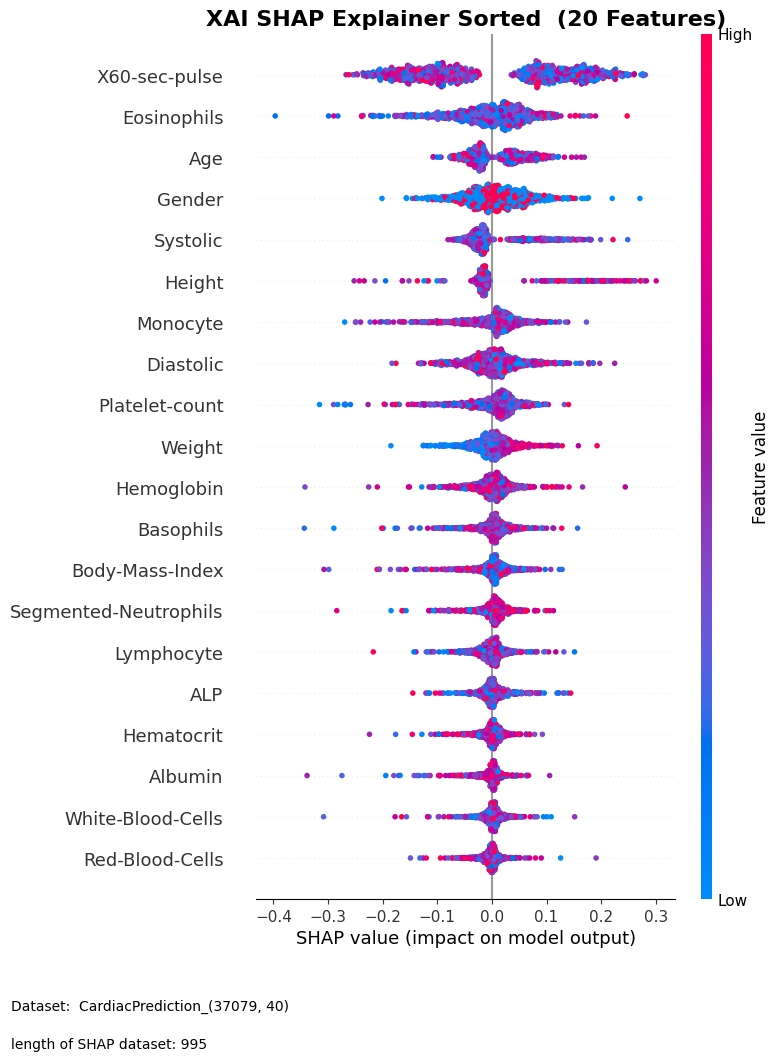

In [21]:
 
# Calculate feature importance based on the mean absolute SHAP values
feature_importance = (shap_values).mean(axis=0)
top_features_indices_Sorted = np.argsort(feature_importance)[::-1] 
top_features_indices = np.argsort(feature_importance)[::-1][:howManyFeatures]
# Select only the top features and corresponding SHAP values
featureNamesSHAP = X.columns[top_features_indices_Sorted]
top_features = testForShap[:, top_features_indices_Sorted]
top_shap_values = shap_values[:, top_features_indices_Sorted] 

print("\n\n--------------------------------------------------")
print("--------------------------------------------------")
print("Top SHAP values:")
for i in range(len(top_features_indices_Sorted)-1):
    feature_index = top_features_indices_Sorted[i]
    feature_name = feature_names[feature_index]
    shap_value = (top_shap_values[:, i]).mean(axis=0) #np.mean(np.abs(shap_values[:, i]))
    avg_shap_values2[i]= (shap_value * 100.0)
    print(f"{i}, {feature_index}, {feature_name}, {shap_value }")
    #print(f"{feature_name}, { shap_value}")
 
top_10_shap_values = shap_values[:, top_features_indices] 
top_10_feature_names = X.columns[top_features_indices]
# Create a DataFrame for visualization


df_top_10 = pd.DataFrame(data=top_10_shap_values, columns=top_10_feature_names)


shap.summary_plot(top_10_shap_values, testForShap[:, top_features_indices], feature_names=top_10_feature_names, show=False)

ax = mplot.gca() 
ax.set_title("XAI SHAP Explainer Sorted  ({} Features)".format(howManyFeatures) ,fontsize=16, fontweight='bold')     
dataSetString = "Dataset:  {}".format(dataSetName)
testingDatasetString ="length of SHAP dataset: {}".format(len(testForShap)) 
ax.figure.text(0.020, -0.05,  dataSetString, horizontalalignment='left', wrap=False )  
ax.figure.text(0.020, -0.09,  testingDatasetString, horizontalalignment='left', wrap=False )   

picturePath = "{}XAI_SHAP_Explainer_{}_Sorted_numberOfSamples_{}.png".format(dataSetResultDirectory, dataSetName, len(testForShap))
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
mplot.show()
#os.startfile(picturePath)
mplot.close()
 



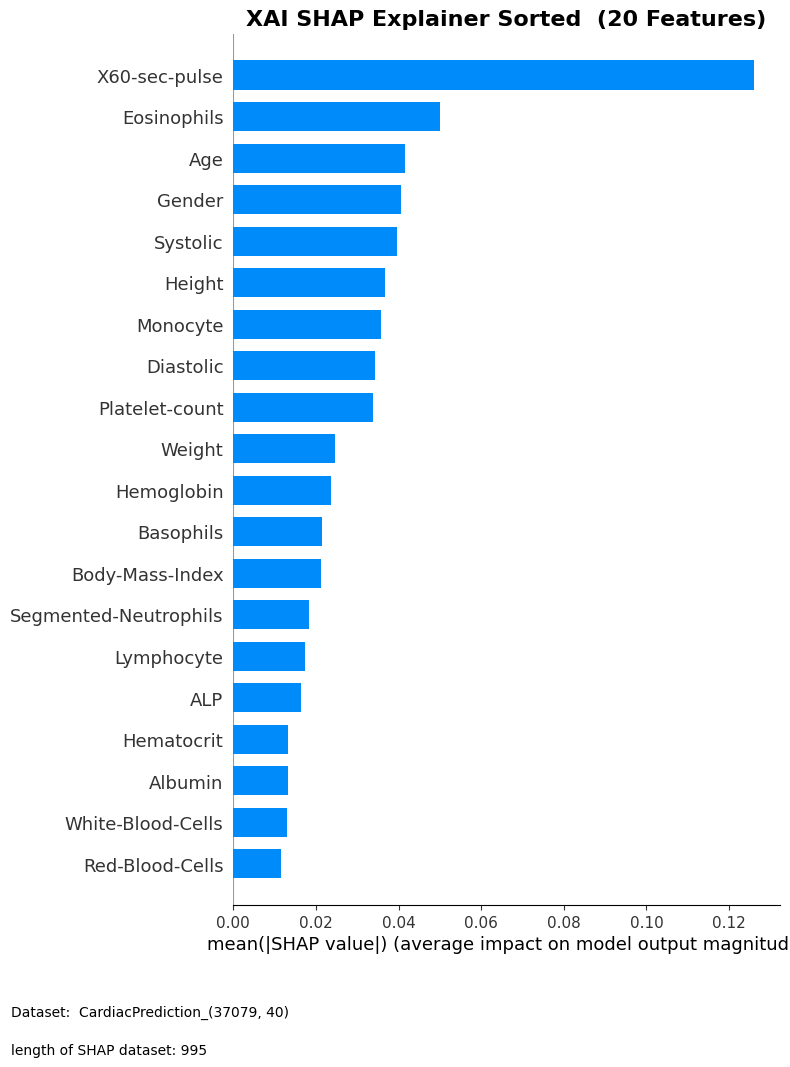

In [10]:
# Plot the summary Bar
shap.summary_plot(top_10_shap_values, testForShap[:, top_features_indices], feature_names=top_10_feature_names, plot_type="bar", show=False)
ax = mplot.gca() 
ax.set_title("XAI SHAP Explainer Sorted  ({} Features)".format(howManyFeatures) ,fontsize=16, fontweight='bold')     
dataSetString = "Dataset:  {}".format(dataSetName)
testingDatasetString ="length of SHAP dataset: {}".format(len(testForShap)) 
ax.figure.text(0.020, -0.05,  dataSetString, horizontalalignment='left', wrap=False )  
ax.figure.text(0.020, -0.09,  testingDatasetString, horizontalalignment='left', wrap=False )   

picturePath = "{}XAI_SHAP_Explainer_Bar_{}_Sorted_numberOfSamples_{}.png".format(dataSetResultDirectory, dataSetName, len(testForShap))
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
mplot.show()
#os.startfile(picturePath)
mplot.close()

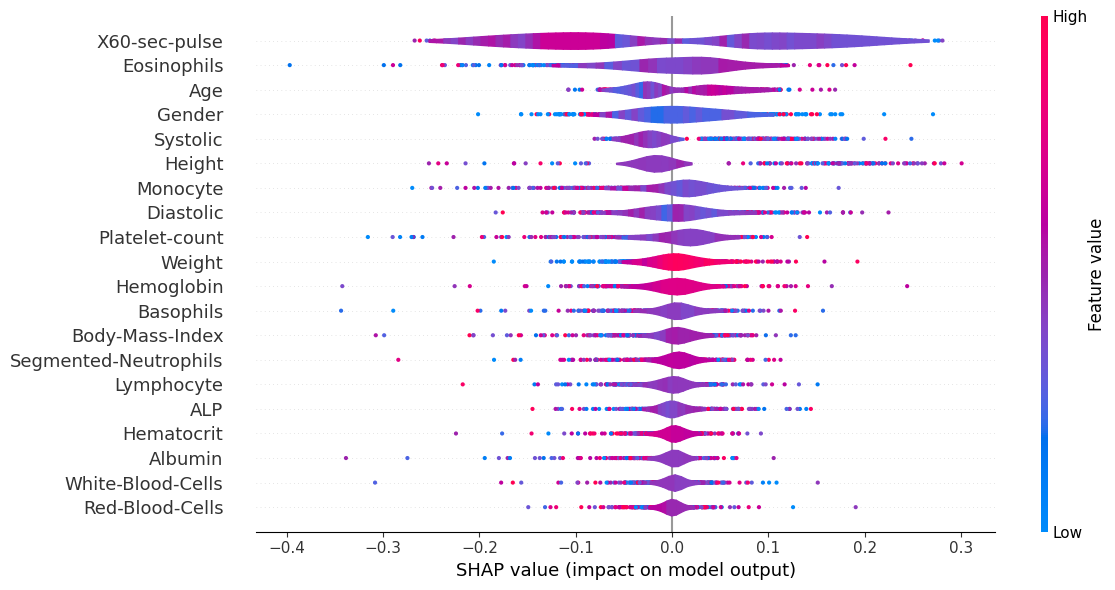

In [11]:
shap.summary_plot(top_shap_values, top_features, feature_names=featureNamesSHAP, plot_type="violin", show=False, plot_size=(12, 6))

picturePath = "{}XAI_SHAP_Explainer_Violin_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, dataSetName, len(testForShap))
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
mplot.show()
mplot.close()

In [ ]:
shap.summary_plot(top_shap_values, top_features, feature_names=featureNamesSHAP, plot_type="layered_violin", show=False )

picturePath = "{}XAI_SHAP_Explainer_layered_violin_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, dataSetName, len(testForShap))
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
mplot.show()
mplot.close()

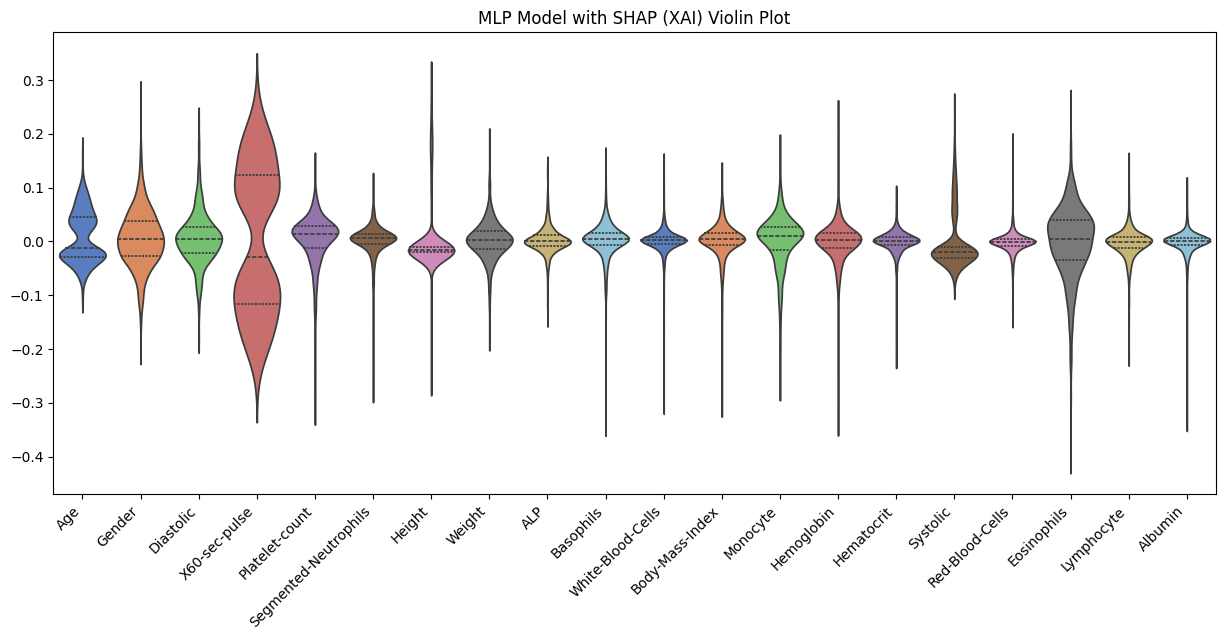

In [12]:
import matplotlib.pyplot as plt

# Plotting with Seaborn's violinplot
plt.figure(figsize=(15, 6))
sns.violinplot(data=df_top_10, inner="quartile", palette="muted") 
plt.title('MLP Model with SHAP (XAI) Violin Plot')
plt.xticks(rotation=45, ha='right')

picturePath = "{}XAI_SHAP_Explainer_SNS_Violinplot_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

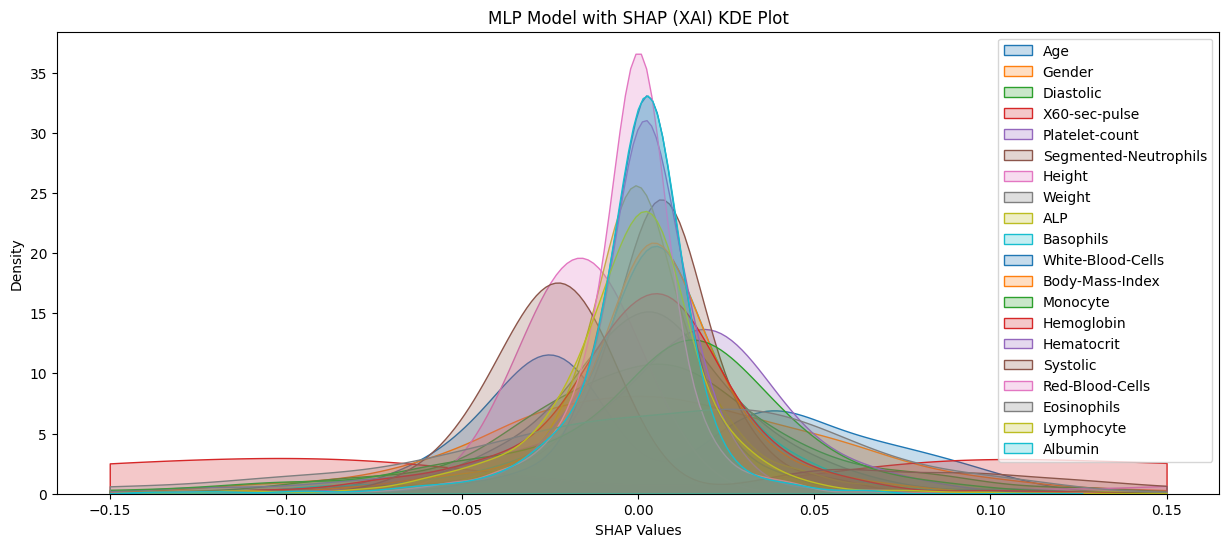

In [14]:
# Set the x-axis range
x_axis_range = (-0.15, 0.15)  # Adjust the range as needed
# Plotting with Seaborn's kdeplot
plt.figure(figsize=(15, 6))
for feature in top_10_feature_names:
    sns.kdeplot(data=df_top_10[feature], label=feature, common_norm=False, common_grid=True, fill=True, clip=x_axis_range)
 
plt.title('MLP Model with SHAP (XAI) KDE Plot')
plt.xlabel('SHAP Values')
plt.ylabel('Density')
plt.legend()
picturePath = "{}XAI_SHAP_Explainer_SNS_KDEplot_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

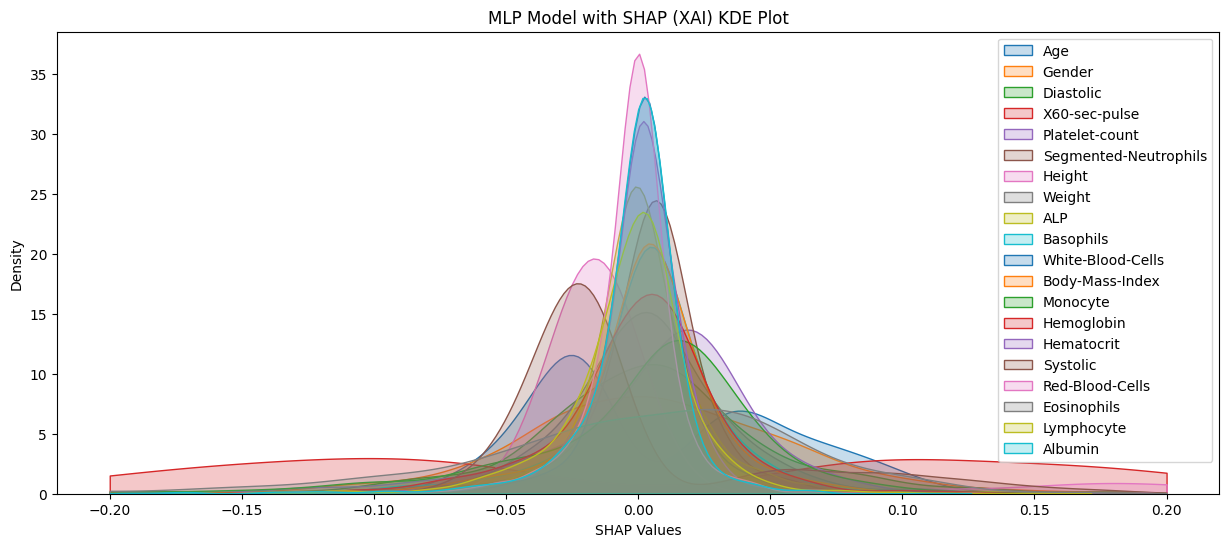

In [15]:
# Set the x-axis range
x_axis_range = (-0.2, 0.2)  # Adjust the range as needed
# Plotting with Seaborn's kdeplot
plt.figure(figsize=(15, 6))
for feature in top_10_feature_names:
    sns.kdeplot(data=df_top_10[feature], label=feature, common_norm=True, common_grid=True, fill=True, clip=x_axis_range)
 
plt.title('MLP Model with SHAP (XAI) KDE Plot')
plt.xlabel('SHAP Values')
plt.ylabel('Density')
plt.legend()
picturePath = "{}XAI_SHAP_Explainer_SNS_KDEplot_2_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

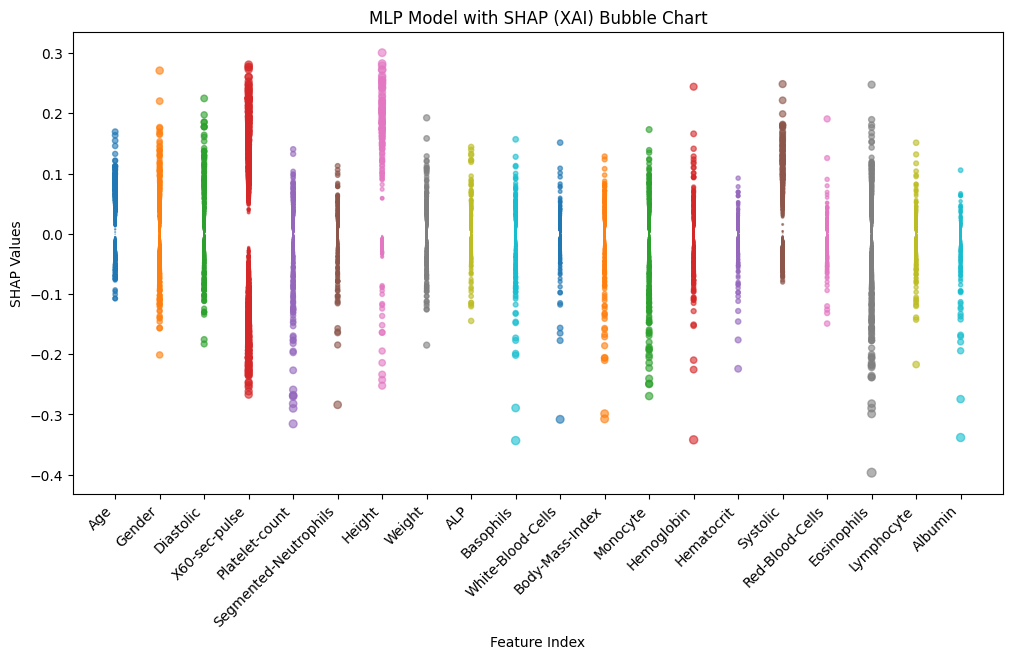

In [17]:
# Plotting a Bubble Chart
plt.figure(figsize=(12, 6))

for i, feature in enumerate(top_10_feature_names):
    size = np.abs(df_top_10[feature]) * 100  # Adjust the scale as needed
    plt.scatter(x=[i] * len(df_top_10), y=df_top_10[feature], s=size, label=feature, alpha=0.6)
 
plt.title('MLP Model with SHAP (XAI) Bubble Chart')
plt.xlabel('Feature Index')
plt.ylabel('SHAP Values')
plt.xticks(range(len(top_10_feature_names)), top_10_feature_names, rotation=45, ha='right')
#plt.legend()

picturePath = "{}XAI_SHAP_Explainer_SNS_BubbleChart_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

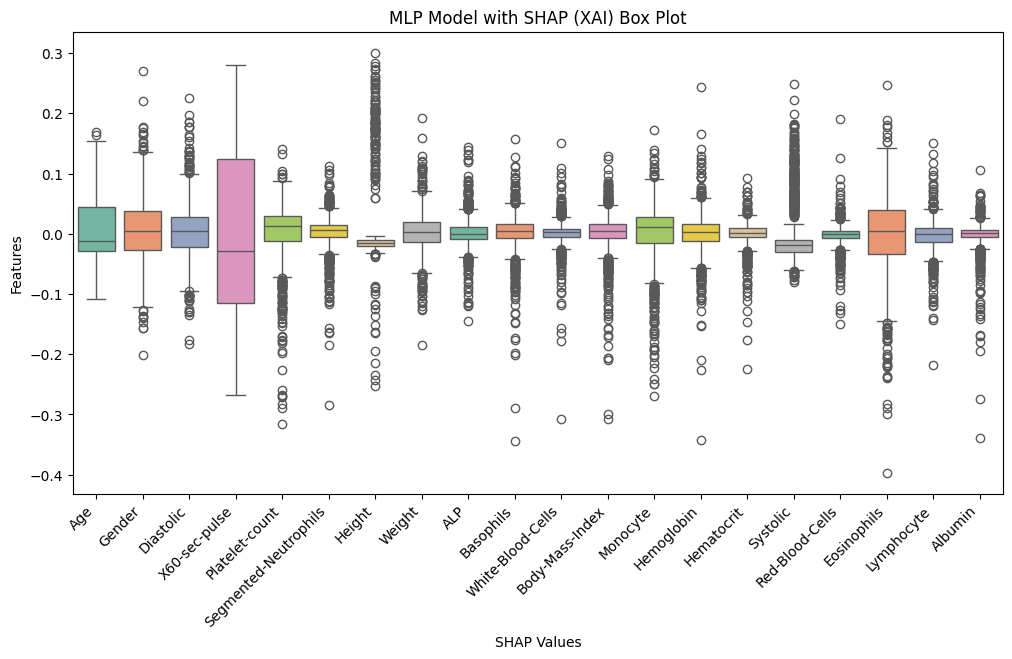

In [18]:
# Plotting a boxplot for the top 10 features
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_10, orient='v', palette='Set2')


plt.title('MLP Model with SHAP (XAI) Box Plot')
plt.xlabel('SHAP Values')
plt.ylabel('Features')
plt.xticks(range(len(top_10_feature_names)), top_10_feature_names, rotation=45, ha='right')

picturePath = "{}XAI_SHAP_Explainer_SNS_BoxPlot_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

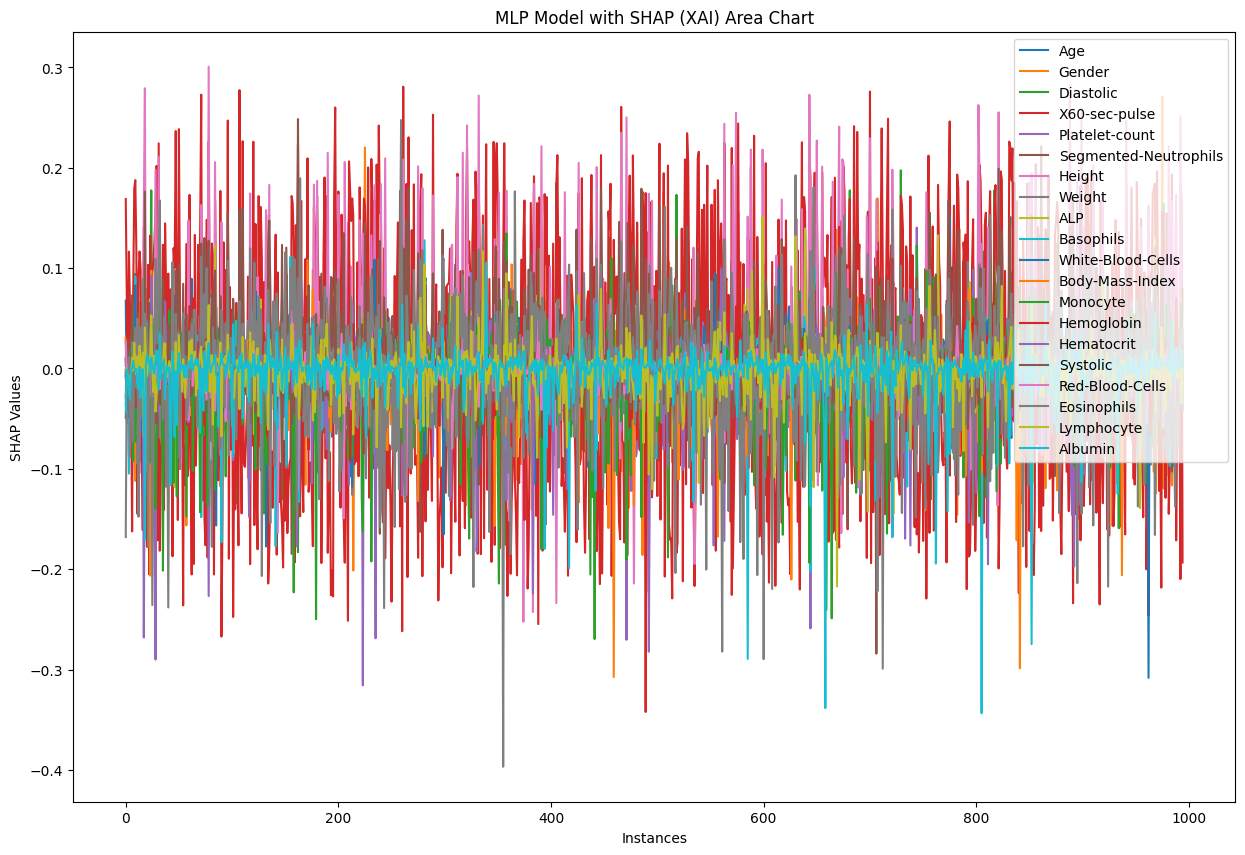

In [19]:
# Plotting an area chart for all SHAP values of the top 10 features
plt.figure(figsize=(15, 10))
for feature in top_10_feature_names:
    sns.lineplot(x=range(df_top_10.shape[0]), y=df_top_10[feature], label=feature)
 
plt.title('MLP Model with SHAP (XAI) Area Chart')

plt.xlabel('Instances')
plt.ylabel('SHAP Values')
plt.legend(loc='upper right')

picturePath = "{}XAI_SHAP_Explainer_SNS_AreaChart_{}_numberOfSamples_{}.png".format(dataSetResultDirectory,  dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

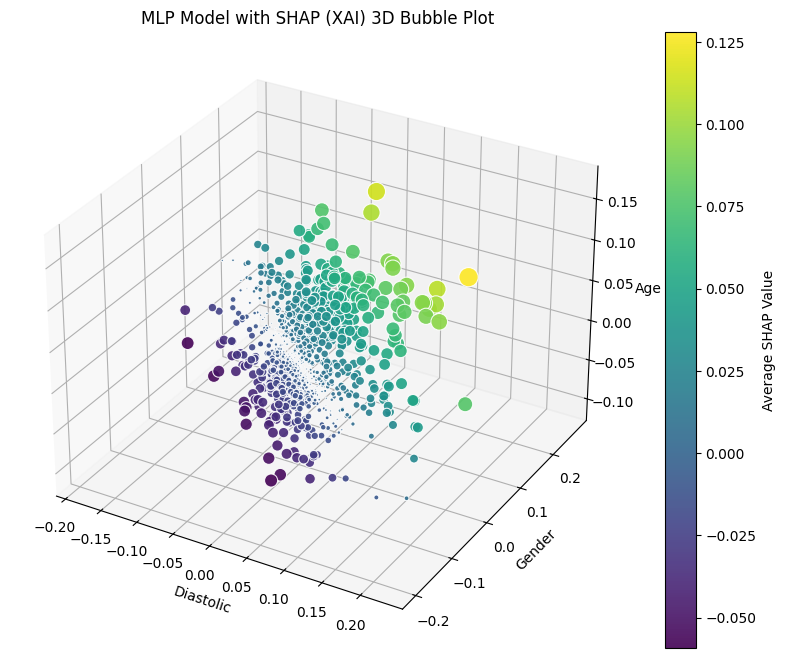

In [22]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming your features are in a pandas DataFrame, you can access feature names
feature_names = X.columns.tolist()
# Get the top 3 features based on their absolute average SHAP values
top_3_feature_indices = np.argsort(np.abs(shap_values.mean(0)))[-3:]
top_3_feature_names = [feature_names[i] for i in top_3_feature_indices]
# Extract SHAP values for the top 3 features
shap_values_top_3 = shap_values[:, top_3_feature_indices]
# Create a DataFrame for visualization
df_top_3 = pd.DataFrame(data=shap_values_top_3, columns=top_3_feature_names)

# Create a 3D bubble plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
 

# Scatter plot with adjusted size and color
scatter = ax.scatter(df_top_3[top_3_feature_names[0]], df_top_3[top_3_feature_names[1]], df_top_3[top_3_feature_names[2]],
                     s=1500 * np.abs(df_top_3.mean(axis=1)),  # Adjust the size
                     c=df_top_3.mean(axis=1), cmap='viridis', alpha=0.9, edgecolors='w', linewidth=0.8)  # Adjust the color

# Add labels and title
ax.set_xlabel(top_3_feature_names[0])
ax.set_ylabel(top_3_feature_names[1])
ax.set_zlabel(top_3_feature_names[2])
ax.set_title('3D Bubble Plot of Top 3 Features')
plt.title('MLP Model with SHAP (XAI) 3D Bubble Plot')


# Add colorbar
colorbar = plt.colorbar(scatter, ax=ax, label='Average SHAP Value')

picturePath = "{}XAI_SHAP_Explainer_SNS_BubblePlot_3D_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

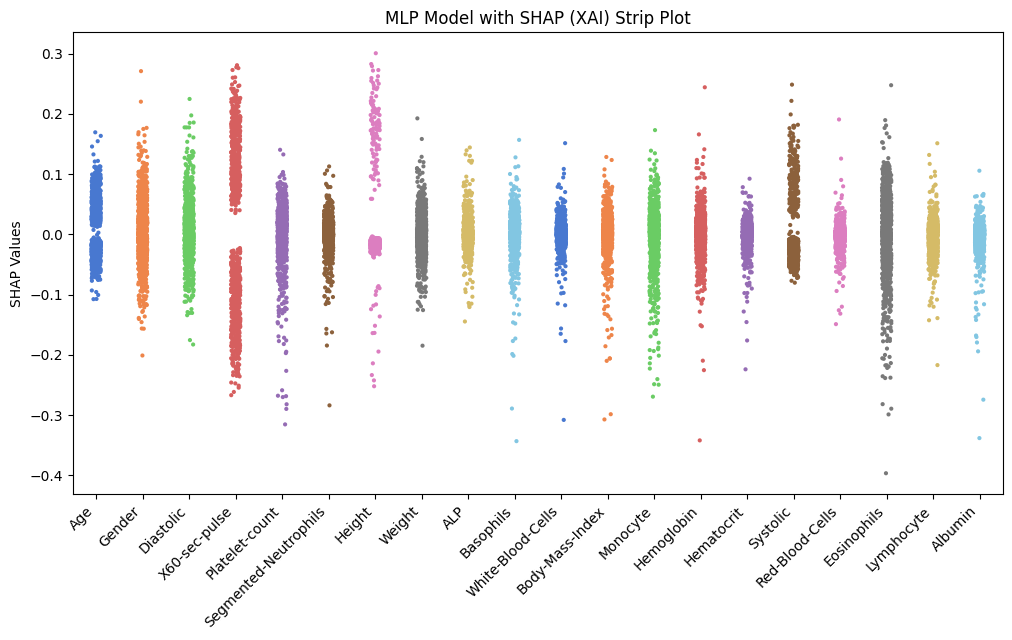

In [20]:
# Plotting with Seaborn's swarmplot (Beeswarm plot) 
plt.figure(figsize=(12, 6))
sns.stripplot(data=df_top_10, palette="muted", size=3, jitter=True)  # Use jitter=True for strip plot

plt.title('MLP Model with SHAP (XAI) Strip Plot')
plt.ylabel('SHAP Values')
plt.xticks(rotation=45, ha='right')

picturePath = "{}XAI_SHAP_Explainer_SNS_Stripplot_{}_numberOfSamples_{}.png".format(dataSetResultDirectory,  dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()


76.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
70.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
72.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
52.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
74.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
81.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
83.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
78.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
82.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
79.1% of the points cannot be placed; you may want to d

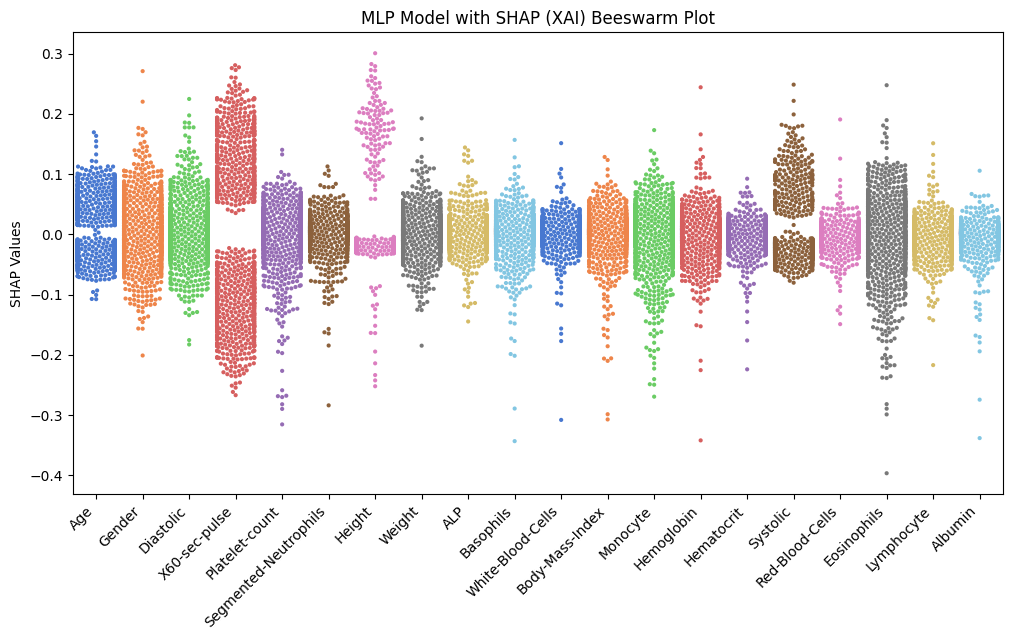

In [23]:
# Plotting with Seaborn's swarmplot (Beeswarm plot)

plt.figure(figsize=(12, 6))
sns.swarmplot(data=df_top_10, palette="muted", size=3) 
plt.title('MLP Model with SHAP (XAI) Beeswarm Plot')
plt.ylabel('SHAP Values')
plt.xticks(rotation=45, ha='right')

picturePath = "{}XAI_SHAP_Explainer_SNS_Beeswarmplot_{}_numberOfSamples_{}.png".format(dataSetResultDirectory,  dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()